# Experiment to use neural network to capture interation effects in logistic price-response model

## Preliminaries

In [576]:
import numpy as np
import pandas as pd
import random
from numpy.random import default_rng
import math
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from sklearn.model_selection import train_test_split


In [577]:
%matplotlib inline

# Toy example to check can generate data and recover parameters correctly

## Generate dummy data to work with

In [578]:
data_params = {
    'intercept_A': -1,
    'intercept_B': 1,
    'price_slope_A': -1,
    'price_slope_B':-2,
    'pct_A':0.5,
    'noise_sd':0.2,
    'num_rows':1000,
    'price_min':1,
    'price_max':100
}

In [579]:
rng = default_rng()
is_A = rng.binomial(1, data_params['pct_A'], data_params['num_rows'])
is_B = 1 - is_A
real_price = rng.uniform(data_params['price_min'], data_params['price_max'], data_params['num_rows'])
price =  ( real_price - np.mean(real_price) ) / np.std(real_price)
price_A = is_A * price
price_B = is_B * price
noise = rng.normal(0, data_params['noise_sd'], data_params['num_rows'])
xB = is_A*data_params['intercept_A'] + is_B*data_params['intercept_B'] \
    + price_A*data_params['price_slope_A'] + price_B*data_params['price_slope_B'] + noise
response = 1 / ( 1 + np.exp(-1*xB))

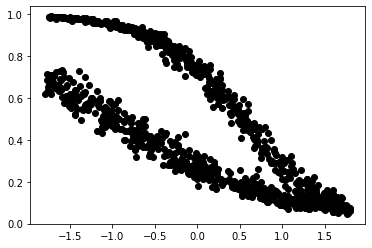

In [580]:
plt.plot(price, response, 'o', color='black')

In [581]:
a = np.column_stack((is_A, is_B, price, price_A, price_B, noise, xB, response))

In [582]:
df = pd.DataFrame(a, columns=['is_A', 'is_B', 'price', 'price_A', 'price_B', 'noise', 'xB', 'response'])

In [583]:
df.sample(3)

,is_A,is_B,price,price_A,price_B,noise,xB,response
358,1.0,0.0,-1.388281,-1.388281,-0.000000,0.602799,0.991080,0.729301
813,0.0,1.0,-1.304861,-0.000000,-1.304861,-0.155833,3.453889,0.969347
788,0.0,1.0,0.760644,0.000000,0.760644,-0.062499,-0.583787,0.358062


## Prep data for modelling

### Test / train split

In [584]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('response',axis=1), df['response'], test_size=0.30, random_state=101)

### Create generator to yield batches for NN training

In [585]:
def get_batch(X, X_cols, y, batch_size=56):
    X = X[X_cols]
    l = len(X)
    i = 0
    while i + 1 < l:
        first = i
        last = min(first+batch_size, l)
        yield torch.tensor(X[first:last].values.astype(np.float32)), torch.tensor(y[first:last].values.astype(np.float32))
        i = last

## Define NN model for predicting response

In [586]:
class Predictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2, bias=False)
        #self.fc2 = nn.Linear(2, 2)
        
    def forward(self, x):
        
        # assume price is in the last column of x...only use non-price columns in NN
        price = x[:,-1]
        x = x[:,:-1]
        
        # pass x through fully connected layers, no activation for now....
        x = self.fc1(x)
        #x = self.fc2(x)
        
        # calculate
        xB = x[:,0] + x[:,1]*price
        #response = 1 / ( 1 + torch.exp(-xB))
        
        return xB

In [592]:
model = Predictor()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.03)
epochs = 30

In [593]:
for e in range(epochs):
    train_batch = get_batch(X_train,['is_A', 'is_B', 'price'], y_train, 10)
    running_loss = 0
    batch_num = 0
    for X, y in train_batch:
        
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        batch_num += 1

    print(f"Training loss: {running_loss/batch_num}")

Training loss: 0.5782867435898099
Training loss: 0.5505584146295275
Training loss: 0.5323410715375628
Training loss: 0.519867776121412
Training loss: 0.511010502917426
Training loss: 0.5045268948589052
Training loss: 0.499660610301154
Training loss: 0.49593199236052377
Training loss: 0.4930254931960787
Training loss: 0.4907267566238131
Training loss: 0.4888861238956451
Training loss: 0.4873965740203857
Training loss: 0.48617996403149194
Training loss: 0.4851782206978117
Training loss: 0.4843474954366684
Training loss: 0.4836541929415294
Training loss: 0.4830723094088691
Training loss: 0.482581433228084
Training loss: 0.48216541537216734
Training loss: 0.4818113778318678
Training loss: 0.4815089417355401
Training loss: 0.4812496832438878
Training loss: 0.4810267508029938
Training loss: 0.48083448112010957
Training loss: 0.4806682139635086
Training loss: 0.4805240946156638
Training loss: 0.4803988767521722
Training loss: 0.48028985687664577
Training loss: 0.4801947691610881
Training loss

In [595]:
with torch.no_grad():
    logit_pred = model(torch.tensor(X_test[['is_A', 'is_B', 'price']].values.astype(np.float32)))
    
pred = 1 / ( 1 + torch.exp(-logit_pred))

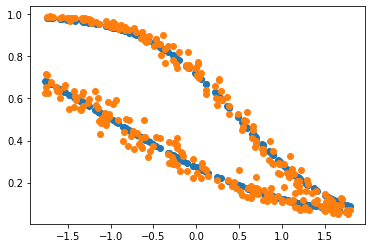

In [596]:
plt.plot(X_test.price, pred, 'o')
plt.plot(X_test.price, y_test, 'o')

In [597]:
print(model.fc1.weight)
print('Correct values used to generate raw data:')
print(np.array([[data_params['intercept_A'], data_params['intercept_B']],
      [data_params['price_slope_A'], data_params['price_slope_B']]]))

Parameter containing:
tensor([[-0.9773,  0.9204],
        [-0.9868, -1.8189]], requires_grad=True)
Correct values used to generate raw data:
[[-1  1]
 [-1 -2]]


# More complex example

## Generate dummy data to work with

In [602]:
data_params = {
    'num_features': 5,
    'features_mean':0,
    'features_std':1,
    'main_effect_mean':0,
    'main_effect_std':1,
    'price_slope':-1,
    'price_effect_max':-0.1,
    'price_effect_min':-2,
    'num_interactions': 2,
    'num_price_interactions':2,
    'interaction_effect_mean':0,
    'interaction_effect_std':1,   
    'price_interaction_effect_max':-0.1,
    'price_interaction_effect_min':-0.5,    
 
    'noise_sd':0.1,
    'num_rows':10000,
    'price_min':1,
    'price_max':100
}

In [663]:
rng = default_rng()

x_1 = rng.normal(data_params['features_mean'], data_params['features_std'], (data_params['num_rows'], data_params['num_features']))
B_1 = rng.normal(data_params['main_effect_mean'], data_params['main_effect_std'], data_params['num_features'])

real_price = rng.uniform(data_params['price_min'], data_params['price_max'], data_params['num_rows'])
price =  ( real_price - np.mean(real_price) ) / np.std(real_price)
price = price.reshape(-1,1)

B_price = np.array([data_params['price_slope']])

x_1p = x_1 * price
B_1p = rng.uniform(data_params['price_effect_min']/data_params['num_features'], data_params['price_effect_max']/data_params['num_features'], data_params['num_features'])

feature_pairs = []
for i in range(data_params['num_features']):
    for j in range(data_params['num_features']):
        if i != j:
            feature_pairs.append((i,j))

interactions = random.sample(feature_pairs, data_params['num_interactions'])
price_interactions = random.sample(feature_pairs, data_params['num_price_interactions'])

x_2 = np.empty(shape=(data_params['num_rows'], data_params['num_interactions']))
for i, pair in enumerate(interactions):
    x_2[:,i] = x_1[:,pair[0]] * x_1[:,pair[1]]
x_2p = x_2 * price

B_2 = rng.normal(data_params['interaction_effect_mean'], data_params['interaction_effect_std'], data_params['num_interactions'])
B_2p = rng.uniform(data_params['price_interaction_effect_min']/data_params['num_price_interactions'], data_params['price_interaction_effect_max']/data_params['num_price_interactions'], data_params['num_price_interactions'])

x = np.column_stack((x_1, price, x_1p, x_2, x_2p))
B = np.concatenate((B_1, B_price, B_1p, B_2, B_2p))
xB = np.dot(x, B)

noise = rng.normal(0, data_params['noise_sd'], data_params['num_rows'])

response = 1 / ( 1 + np.exp(-1*(xB + noise)))

alpha = np.dot( np.column_stack((x_1, x_2)), np.concatenate((B_1, B_2)) )
beta = (xB - alpha) / price.reshape(-1)

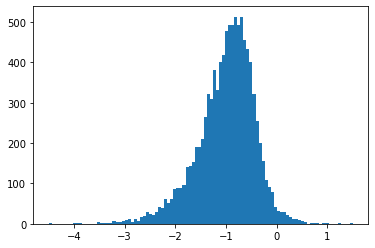

In [664]:
_ = plt.hist(beta, bins=100)

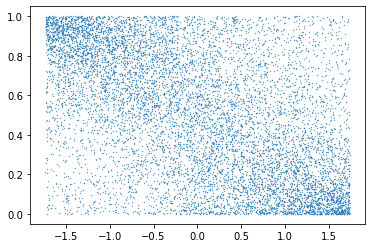

In [670]:
plt.scatter(price[beta < 0], response[beta < 0], s = 0.1)

In [609]:
def grid_plot(alpha, beta, rows=8, columns=6):
    
    idx = random.sample(range(len(alpha)),rows*columns)
    price = np.arange(-2,2,0.1)
    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(15,10), sharex=True, sharey=True)
    for i, ax in enumerate(axes.flatten()):
        logit = alpha[i] + price*beta[i]
        response = 1 / ( 1 + np.exp(-1*logit))
        ax.plot(price, response)

    plt.show()

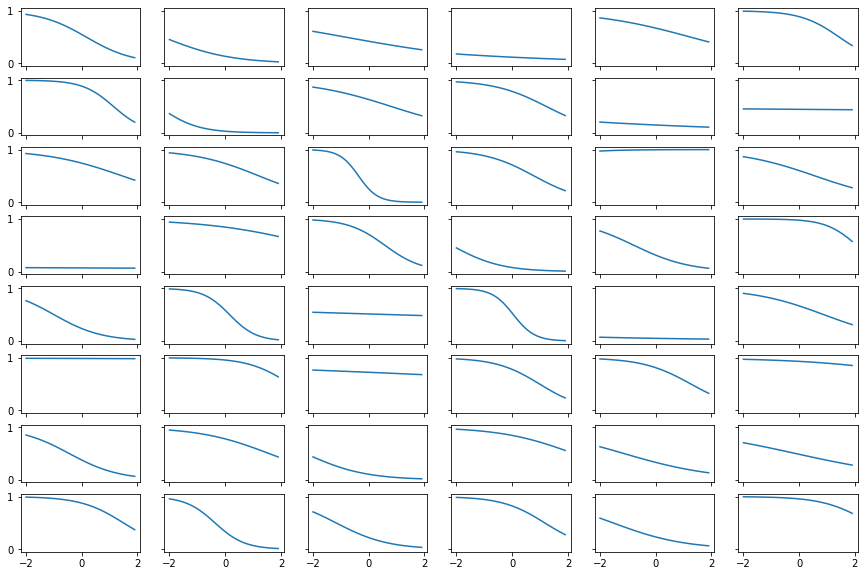

In [610]:
grid_plot(alpha, beta)

In [611]:
a = np.column_stack((x_1, price, alpha, beta, response))
b = a[beta<0]

In [612]:
x_cols = [ "x_" + str(i+1) for i in range(data_params['num_features']) ]

In [613]:
df = pd.DataFrame(b, columns=x_cols + ['price', 'alpha', 'beta', 'response'])

In [614]:
df.sample(3)

,x_1,x_2,x_3,x_4,x_5,price,alpha,beta,response
3184,0.727275,0.902597,1.149051,-0.576336,-0.005696,-1.318544,0.751269,-1.056114,0.891226
6190,-0.466890,-2.017127,0.002302,-0.027231,-0.399830,0.120822,-2.840563,-0.544347,0.056261
3399,-1.209981,0.110526,0.200489,1.055331,-0.295118,0.199149,0.949361,-0.722249,0.695413


## Prep data for modelling

### Test train split

In [615]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('response',axis=1), df['response'], test_size=0.30, random_state=101)

### Generator to yield batches of data for NN training

In [616]:
def get_batch(X, X_cols, y, batch_size=56):
    X = X[X_cols]
    l = len(X)
    i = 0
    while i + 1 < l:
        first = i
        last = min(first+batch_size, l)
        yield torch.tensor(X[first:last].values.astype(np.float32)), torch.tensor(y[first:last].values.astype(np.float32))
        i = last

## NN model to predict response

In [617]:
class Predictor(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features
        fc1out_num_features = max(2, int(self.num_features/2))
        self.fc1 = nn.Linear(self.num_features, fc1out_num_features)
        self.fc2 = nn.Linear(fc1out_num_features, 2, bias=False)
        
    def forward(self, x):
        
        # assume price is in the last column of x...only use non-price columns in NN
        price = x[:,-1]
        x = x[:,:-1]
        
        # pass x through fully connected layers, no activation, dropout, normalisation etc. for now....
        x = self.fc1(x)
        x = self.fc2(x)
        
        # calculate
        alpha = x[:,0] 
        beta = x[:,1]
        xB = alpha + beta*price
        #response = 1 / ( 1 + torch.exp(-xB))
        
        return xB, alpha, beta

In [709]:
model = Predictor(data_params['num_features'])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)
epochs = 30

In [715]:
for e in range(epochs):
    train_batch = get_batch(X_train,x_cols+['price'], y_train, 128)
    running_loss = 0
    batch_num = 0
    for X, y in train_batch:
        
        optimizer.zero_grad()
        logits, alpha, beta = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        batch_num += 1

    print(f"Training loss: {running_loss/batch_num}")

Training loss: 0.49607840953049837
Training loss: 0.49585726857185364
Training loss: 0.4957922873673616
Training loss: 0.4957660878146136
Training loss: 0.49575390032044164
Training loss: 0.49574778587729845
Training loss: 0.49574451038131007
Training loss: 0.4957426764346935
Training loss: 0.4957416041029824
Training loss: 0.4957409523151539
Training loss: 0.49574055053569654
Training loss: 0.49574028617805904
Training loss: 0.49574011619444247
Training loss: 0.495740012438209
Training loss: 0.49573993848429787
Training loss: 0.4957398810872325
Training loss: 0.4957398413508027
Training loss: 0.4957398214825877
Training loss: 0.49573980547763685
Training loss: 0.49573978947268593
Training loss: 0.49573977677910414
Training loss: 0.49573976629310185
Training loss: 0.49573975635899437
Training loss: 0.4957397475286766
Training loss: 0.4957397458729921
Training loss: 0.4957397409059383
Training loss: 0.4957397326275154
Training loss: 0.495739726556672
Training loss: 0.49573972214151313
T

In [716]:
with torch.no_grad():
    pred_logit, pred_alpha, pred_beta = model(torch.tensor(X_test[x_cols+['price']].values.astype(np.float32)))

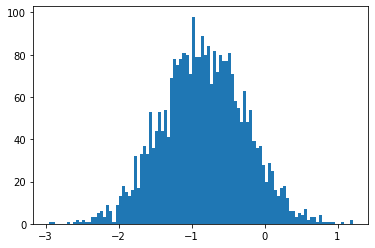

In [717]:
_ = plt.hist(pred_beta.numpy(), bins=100)

In [718]:
def grid_plot(pred_alpha, pred_beta, actual_alpha, actual_beta, rows=8, columns=6):
    
    idx = random.sample(range(len(pred_alpha)),rows*columns)
    price = np.arange(-2,2,0.1)
    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(15,10), sharex=True, sharey=True)
    for i, ax in enumerate(axes.flatten()):
        pred_logit = pred_alpha[i] + price*pred_beta[i]
        pred_response = 1 / ( 1 + np.exp(-1*pred_logit))
        actual_logit = actual_alpha[i] + price*actual_beta[i]
        actual_response = 1 / ( 1 + np.exp(-1*actual_logit))        
        ax.plot(price, pred_response, price, actual_response)

    handles = plt.gca().get_lines()
    labels = ['pred','actual']
    fig.legend(handles, labels, loc='upper center')
    plt.show()

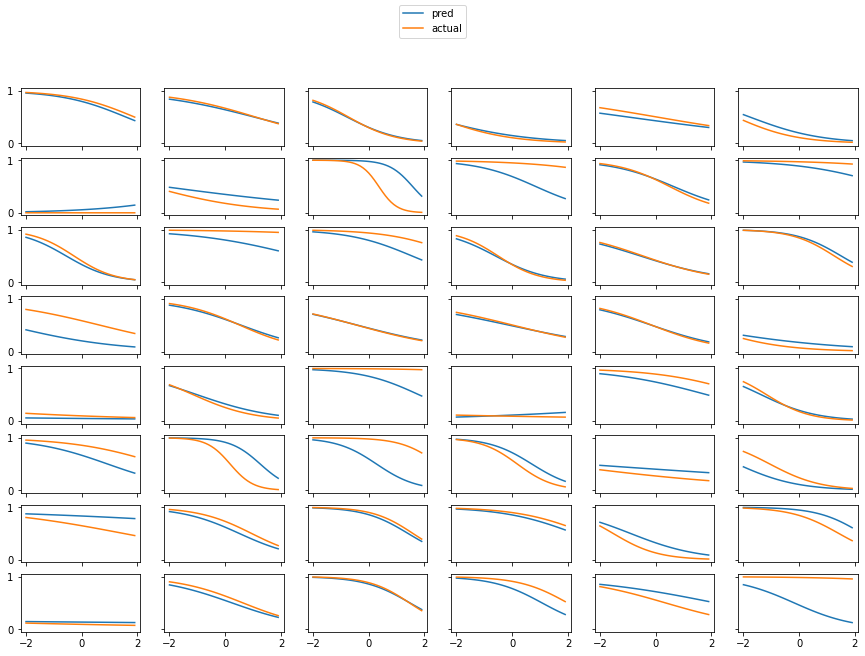

In [719]:
grid_plot(pred_alpha.numpy(), pred_beta.numpy(), X_test['alpha'].to_numpy(), X_test['beta'].to_numpy())